<a href="https://colab.research.google.com/github/HoangKhoi1704/Temp/blob/main/AppleStock_Analyse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Download thư viện ta (Technical Analysis)</h1>
<p>Dùng để xây dựng chiến lược lược giao dịch định lượng</p>

In [1]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=1543b4f5abf97332f4bc5abcc5b86c1522dbd7c0fc86d841ead9f228cd660532
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import ta
from ta.momentum import RSIIndicator
from ta.trend import MACD

<h1>Câu 1: Cách thu thập dữ liệu<h1>
<p>dữ liệu là mã chứng khoán Apple được lấy từ thư viện tfinance của python và dùng giá đóng cửa để phân tích và xây dựng các chiến lược</p>

In [3]:
# Tải dữ liệu cổ phiếu Apple từ 2020 đến 2024
dt = yf.download('AAPL', start='2020-01-01', end='2024-12-31')
dt.to_csv('AAPL.csv')

df = dt[['Close', 'Volume']].reset_index()
df.columns = ['Date', 'Close', 'Volume']
df.set_index('Date', inplace=True)

# Chuyển sang dữ liệu theo tuần
df_weekly = df.resample('W').agg({
    'Close': 'last',
    'Volume': 'sum'
})

# Drop rows with NaN values resulting from resampling
df_weekly.dropna(inplace=True)

# Reset the index to make 'Date' a column again
df_weekly.reset_index(inplace=True)
dt = df_weekly
df = dt

df

/tmp/ipython-input-3-549392369.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dt = yf.download('AAPL', start='2020-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed


,Date,Close,Volume
0,2020-01-05,71.914825,281803200
1,2020-01-12,75.033875,670091600
2,2020-01-19,77.064911,652055600
3,2020-01-26,76.963341,463685200
4,2020-02-02,74.835632,866734800
...,...,...,...
257,2024-12-08,242.255600,208286500
258,2024-12-15,247.532883,192702600
259,2024-12-22,253.877594,368202900
260,2024-12-29,254.974930,133685900


<h1>Câu 2: Trực quan hóa dữ liệu: giá đóng cửa từ đầu 2020 đến cuối 2024</h1>

In [4]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Create subplots
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    subplot_titles=('Biểu đồ giá đóng cửa cổ phiếu AAPL', 'Biểu đồ khối lượng giao dịch cổ phiếu AAPL theo tuần'),
                    vertical_spacing=0.1)

# Add Close price trace
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], mode='lines', name='Close Price'), row=1, col=1)

# Add Volume trace
fig.add_trace(go.Bar(x=df['Date'], y=df['Volume'], name='Volume'), row=2, col=1)

# Update layout
fig.update_layout(height=600, title_text='Biểu đồ giá và khối lượng giao dịch cổ phiếu AAPL')

fig.show()

<h1>Câu 3: Tiền xử lý dữ liệu</h1>


*   Kiểm tra xem có missing value không
*   Dùng Boxplot để xác định giá trị ngoại lai
*   Giá trung bình
*   Giá trung vị
*   Giá lớn nhất
*   Giá nhỏ nhất







In [5]:
print(df.isnull().sum())

# Kết quả cho thấy không có giá trị nào missing

Date      0
Close     0
Volume    0
dtype: int64


In [6]:
from scipy import stats

def clean_data(dt):
    df = dt.copy()
    df.drop_duplicates(inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df[df['Close'] > 0]
    z_scores = np.abs(stats.zscore(df['Close']))
    df = df[z_scores <= 3]

    df = df[df['Volume'] > 0]
    z_scores = np.abs(stats.zscore(df['Volume']))
    df = df[z_scores <= 3]

    return df

clean_data(dt)

,Date,Close,Volume
0,2020-01-05,71.914825,281803200
1,2020-01-12,75.033875,670091600
2,2020-01-19,77.064911,652055600
3,2020-01-26,76.963341,463685200
4,2020-02-02,74.835632,866734800
...,...,...,...
257,2024-12-08,242.255600,208286500
258,2024-12-15,247.532883,192702600
259,2024-12-22,253.877594,368202900
260,2024-12-29,254.974930,133685900


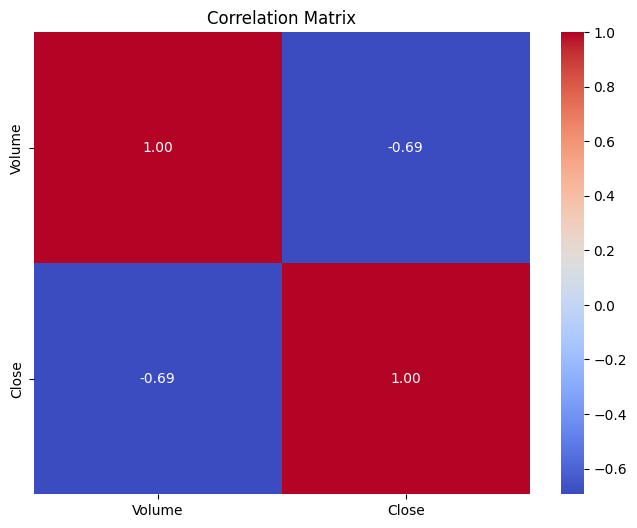

In [7]:
df = dt[['Date', 'Volume', 'Close']]
df.reset_index(drop=True, inplace=True)

# Calculate the correlation matrix
correlation_matrix = df.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [8]:
print(f"Giá trị trung bình của cổ phiếu là: {int(df['Close'].mean())} $")
print(f"Giá trị trung vị của cổ phiếu là: {int(df['Close'].median())} $")
print(f"Giá trị lớn nhất của cổ phiếu là: {int(df['Close'].max())} $")
print(f"Giá trị nhỏ nhất của cổ phiếu là: {int(df['Close'].min())} $")

Giá trị trung bình của cổ phiếu là: 152 $
Giá trị trung vị của cổ phiếu là: 151 $
Giá trị lớn nhất của cổ phiếu là: 254 $
Giá trị nhỏ nhất của cổ phiếu là: 55 $


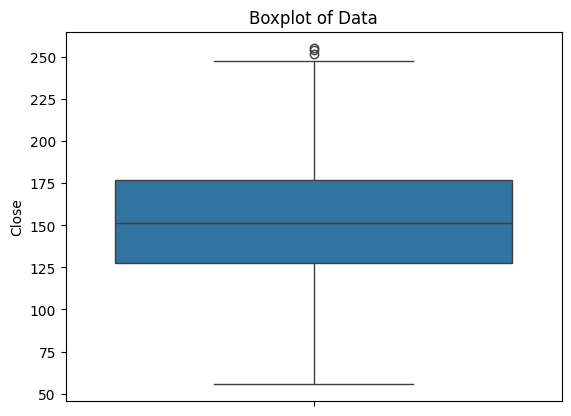

In [9]:
# Biểu đồ boxplot để xác định các giá trị ngoại lai
sns.boxplot(data=df['Close'])
plt.title('Boxplot of Data')
plt.show()

<h1>Câu 4: Xây dựng 3 chiến lược đầu tư</h1>

*   SMA
*   MACD
*   Bollinger Band


**<h2>1 Chiến lược SMA (đường trung bình)</h2>**

*   Là chiến lược dựa trên hai đường trung bình động (moving averages): một ngắn hạn (21 ngày - SMA3 vì đã thay đổi theo tuần) và một dài hạn (140 ngày - SMA20).
*   Khi đường MA ngắn hạn cắt lên đường dài hạn → Tín hiệu MUA (Golden Cross).
*   Khi đường MA ngắn hạn cắt xuống đường dài hạn → Tín hiệu BÁN (Death Cross).





/tmp/ipython-input-10-2643815496.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-10-2643815496.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-10-2643815496.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-

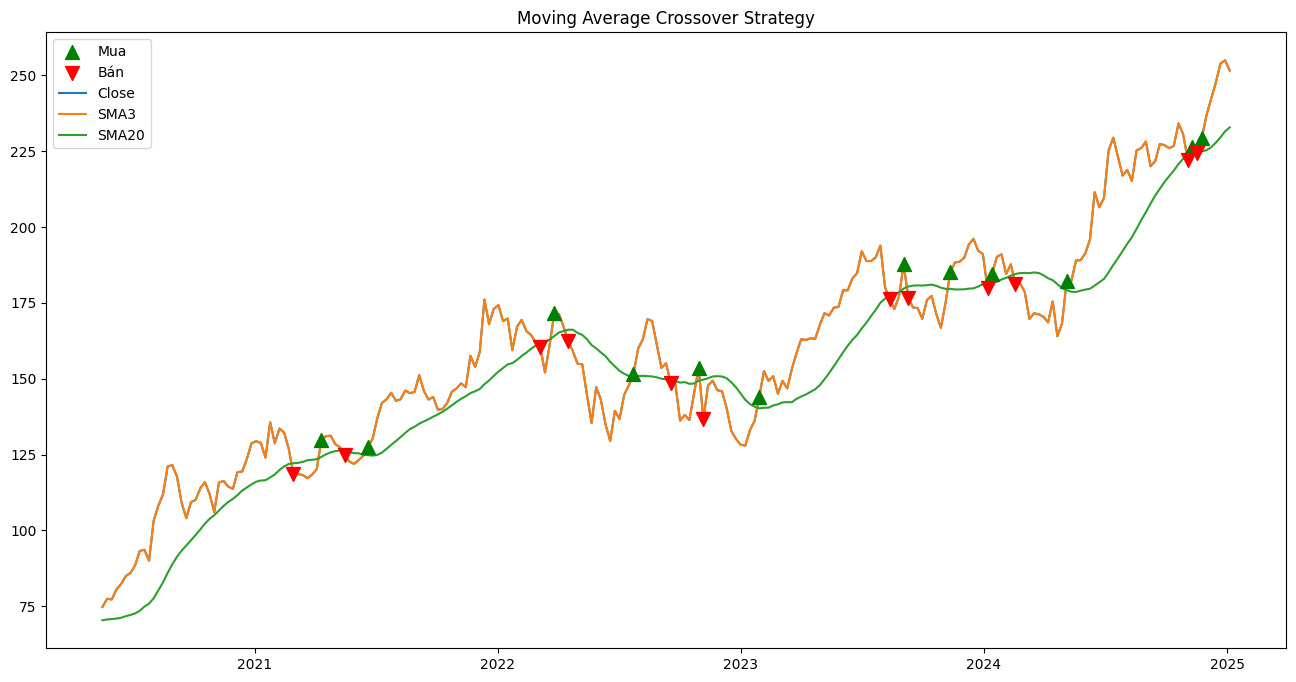

In [10]:
df = dt[['Date', 'Volume', 'Close']]
df.reset_index(drop=True, inplace=True)


df['SMA3'] = df['Close'].rolling(1).mean()
df['SMA20'] = df['Close'].rolling(20).mean()

# Tạo tín hiệu giao dịch
df['SMA_Signal'] = 0
df.loc[df['SMA3'] > df['SMA20'], 'SMA_Signal'] = 1
df.loc[df['SMA3'] < df['SMA20'], 'SMA_Signal'] = -1

# Tạo cột vị thế mua/bán (Long only: 1 for Buy, 0 for Hold/Sell)
df['Position'] = df['SMA_Signal'].shift(1)
df['Position'] = df['Position'].replace(-1, 0) # Assuming a long-only strategy

# Tính chiến lược (lợi nhuận tiềm năng)
df['SMA_Return'] = df['Position'] * df['Close'].pct_change()

data = df[['Date', 'Volume', 'SMA_Return', 'Close', 'SMA3', 'SMA20', 'SMA_Signal', 'Position']].reset_index()

# Xóa các giá trị NaN
df.dropna(inplace=True)

# Xác định vị trí mua/bán
df['Buy_Signal'] = (df['SMA3'] > df['SMA20']) & (df['SMA3'].shift(1) <= df['SMA20'].shift(1))
df['Sell_Signal'] = (df['SMA3'] < df['SMA20']) & (df['SMA3'].shift(1) >= df['SMA20'].shift(1))
buy_signals = df[df['Buy_Signal']]
sell_signals = df[df['Sell_Signal']]

# Vẽ biểu đồ
plt.figure(figsize=(16, 8))

plt.scatter(buy_signals.Date, buy_signals['Close'], marker='^', color='green', label='Mua', s=100, zorder=10)
plt.scatter(sell_signals.Date, sell_signals['Close'], marker='v', color='red', label='Bán', s=100, zorder=10)

plt.plot(df.Date, df['Close'], label='Close')
plt.plot(df.Date, df['SMA3'], label='SMA3')
plt.plot(df.Date, df['SMA20'], label='SMA20')

plt.title('Moving Average Crossover Strategy')
plt.legend()
plt.show()

**<h2>2 Chiến lược MACD</h2>**

*   MACD = EMA(12) - EMA(26)
*   Đường MACD là hiệu của hai đường trung bình động lũy thừa (EMA)
*  Signal line = EMA(9) của MACD
*   Khi MACD cắt lên signal → Tín hiệu mua
*   Khi MACD cắt xuống signal → Tín hiệu bán












/tmp/ipython-input-11-2091179156.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-11-2091179156.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-11-2091179156.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-

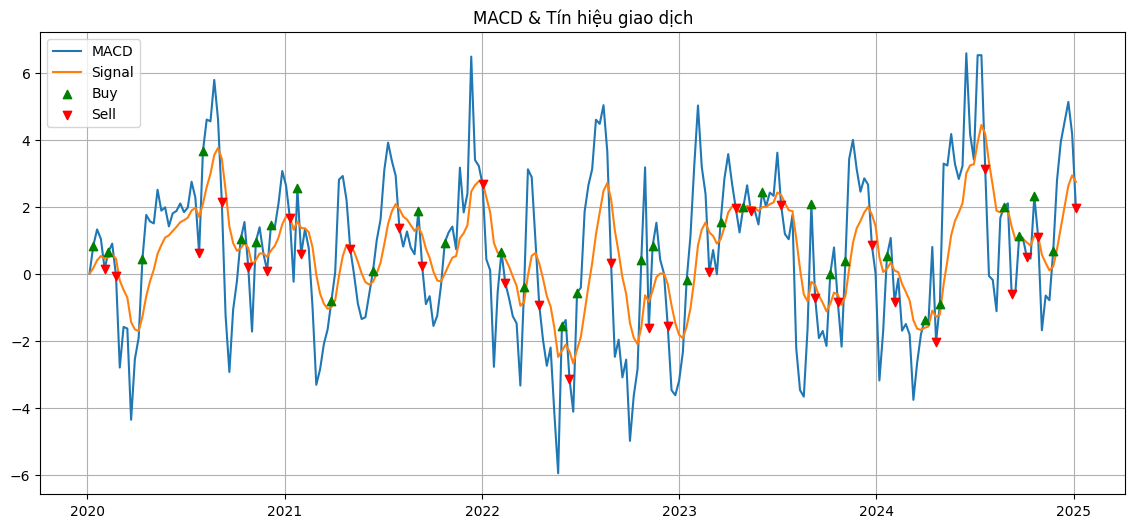

In [11]:
df = dt[['Date', 'Volume', 'Close']]
df.reset_index(drop=True, inplace=True)

# Tính MACD và Signal Line
df['EMA12'] = df['Close'].ewm(span=2, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=4, adjust=False).mean()
df['MACD'] = df['EMA12'] - df['EMA26']
df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Tạo tín hiệu mua/bán
df['MACD_Signal'] = 0
df.loc[(df['MACD'] > df['Signal']) & (df['MACD'].shift(1) <= df['Signal'].shift(1)), 'MACD_Signal'] = 1
df.loc[(df['MACD'] < df['Signal']) & (df['MACD'].shift(1) >= df['Signal'].shift(1)), 'MACD_Signal'] = -1

# Tính lợi nhuận chiến lược
df['MACD_Return'] = df['MACD_Signal'].shift(1) * df['Close'].pct_change()
# df['Cumulative_MACD'] = (1 + df['MACD_Return']).cumprod()

data = pd.concat([data, df[['MACD_Return', 'EMA12', 'EMA26', 'MACD', 'MACD_Signal']]], axis=1)

# (Tuỳ chọn) Vẽ MACD với điểm mua/bán
buy_signals = df[df['MACD_Signal'] == 1]
sell_signals = df[df['MACD_Signal'] == -1]

plt.figure(figsize=(14,6))
plt.plot(df.Date, df['MACD'], label='MACD')
plt.plot(df.Date, df['Signal'], label='Signal')
plt.scatter(buy_signals.Date, buy_signals['MACD'], label='Buy', marker='^', color='green', zorder=10)
plt.scatter(sell_signals.Date, sell_signals['MACD'], label='Sell', marker='v', color='red', zorder=10)
plt.title('MACD & Tín hiệu giao dịch')
plt.legend()
plt.grid(True)
plt.show()


**<h2>3 Chiến lược Bollinger Band (đường trung bình)</h2>**

Gồm 3 dải (bands):
*   Dải giữa	Trung bình động đơn giản (SMA) trong N phiên
*   Dải trên	SMA + k × Độ lệch chuẩn (standard deviation)
*   Dải dưới	SMA - k × Độ lệch chuẩn
*   SMA: 3 tuần
*   K = 1

Diễn giải	Ý nghĩa thực tế:
*   Giá chạm dải trên	Có thể đang ở vùng quá mua – sắp điều chỉnh giảm
*   Giá chạm dải dưới	Có thể đang ở vùng quá bán – có thể đảo chiều tăng
*   Dải bó hẹp (thu hẹp)	Biến động thấp – thường là dấu hiệu sắp có biến động mạnh
*   Dải mở rộng	Biến động mạnh – thị trường đang biến động lớn








/tmp/ipython-input-12-1164659295.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-12-1164659295.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-12-1164659295.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyth

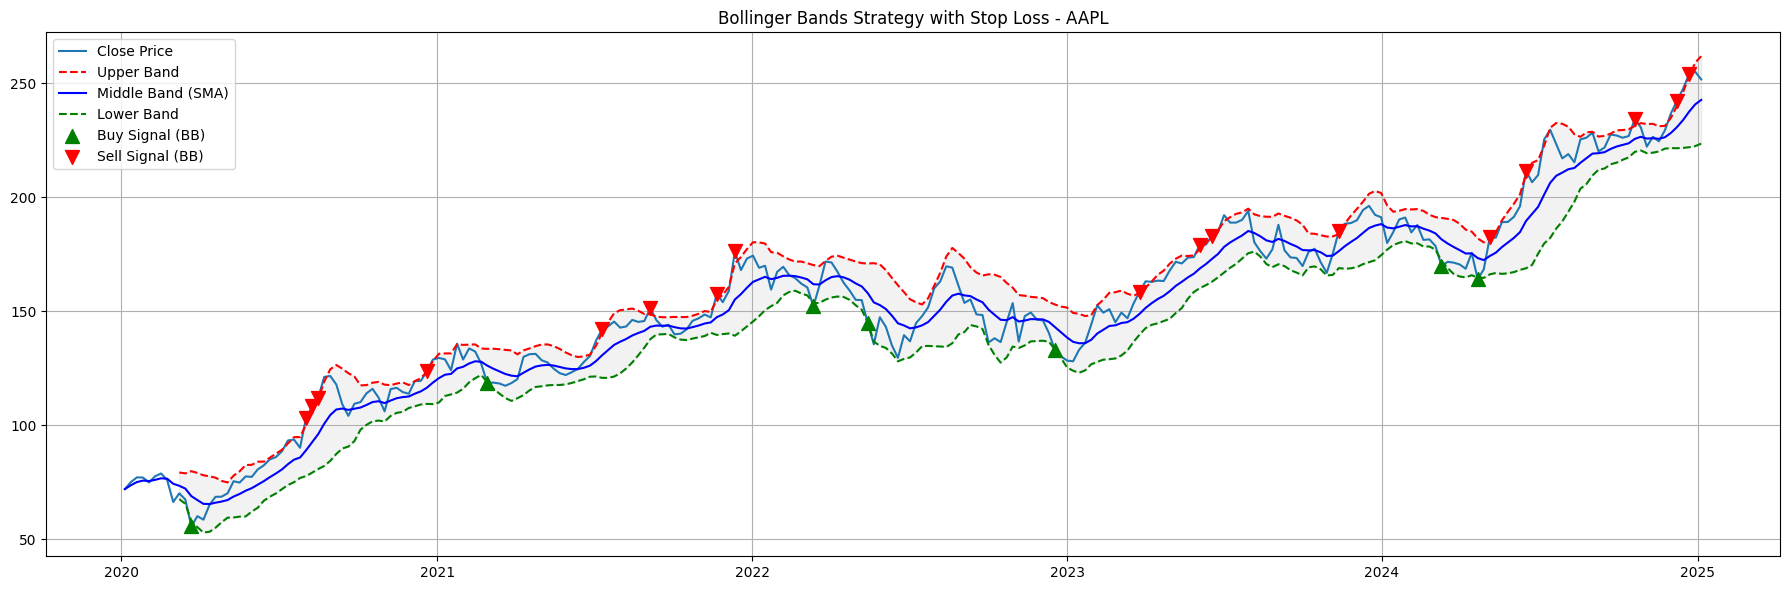

In [12]:
df = dt[['Date', 'Volume', 'Close']]
df.reset_index(drop=True, inplace=True)

# === Cài đặt thông số ===
window = 10
multiplier = 1.5
stop_loss_pct = 0.05  # Stop Loss 5%

# === Tính các chỉ báo kỹ thuật ===
df['SMA'] = df['Close'].ewm(span=window).mean()
df['STD'] = df['Close'].rolling(window=window).std()
df['Upper'] = df['SMA'] + multiplier * df['STD']
df['Lower'] = df['SMA'] - multiplier * df['STD']
df['Volume_SMA'] = df['Volume'].rolling(4).mean()
df['SMA_slow'] = df['Close'].rolling(12).mean()

# === Tín hiệu giao dịch theo BB, Volume và Rule-based ===
df['Signal_BB'] = 0
df.loc[(df['Close'] < df['Lower']) & (df['Volume'] > df['Volume_SMA']) & (df['Close'] < df['SMA_slow']), 'Signal_BB'] = 1
df.loc[(df['Close'] > df['Upper']) & (df['Volume'] > df['Volume_SMA']) & (df['Close'] > df['SMA_slow']), 'Signal_BB'] = -1

# === Tính chiến lược có Stop Loss ===
df['Position'] = 0
df['Trade_Return'] = 0.0
position = 0
entry_price = 0.0

for i in range(1, len(df)):
    signal = df.loc[df.index[i], 'Signal_BB']
    price = df.loc[df.index[i], 'Close']

    # Mở vị thế mới nếu chưa có
    if position == 0:
        if signal == 1:
            position = 1
            entry_price = price
        elif signal == -1:
            position = -1
            entry_price = price

    # Nếu đang giữ vị thế mua
    elif position == 1:
        if (price < entry_price * (1 - stop_loss_pct)) or signal == -1:
            df.loc[df.index[i], 'Trade_Return'] = (price - entry_price) / entry_price
            position = -1 if signal == -1 else 0
            entry_price = price if signal == -1 else 0.0

    # Nếu đang giữ vị thế bán
    elif position == -1:
        if (price > entry_price * (1 + stop_loss_pct)) or signal == 1:
            df.loc[df.index[i], 'Trade_Return'] = (entry_price - price) / entry_price
            position = 1 if signal == 1 else 0
            entry_price = price if signal == 1 else 0.0

# === Cập nhật DataFrame 'data' với các cột liên quan ===
df['BB_Return'] = df['Trade_Return']

if 'BB_Return' in data.columns:
    data = data.drop(columns=['BB_Return'])
data = pd.concat([data, df[['BB_Return', 'Lower', 'Upper', 'Signal_BB']]], axis=1)

# === Đồ thị chiến lược Bollinger Bands ===
plt.figure(figsize=(18, 6))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.plot(df['Date'], df['Upper'], label='Upper Band', color='red', linestyle='--')
plt.plot(df['Date'], df['SMA'], label='Middle Band (SMA)', color='blue')
plt.plot(df['Date'], df['Lower'], label='Lower Band', color='green', linestyle='--')
plt.fill_between(df['Date'], df['Upper'], df['Lower'], color='gray', alpha=0.1)

buy_signals_bb = df[df['Signal_BB'] == 1]
sell_signals_bb = df[df['Signal_BB'] == -1]

plt.scatter(buy_signals_bb['Date'], buy_signals_bb['Close'], marker='^', color='green', label='Buy Signal (BB)', s=100, zorder=10)
plt.scatter(sell_signals_bb['Date'], sell_signals_bb['Close'], marker='v', color='red', label='Sell Signal (BB)', s=100, zorder=10)

plt.title("Bollinger Bands Strategy with Stop Loss - AAPL")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<h1>Câu 5: Đánh giá kết quả</h1>


*   Dùng lợi nhuận tích lũy để đánh giá hiệu quả của các chiến lược. Tổng lợi nhuận tích lũy ban đầu là 1 tương đương 100%
  
*   Lợi nhuận tích lũy biểu diễn tổng phần trăm thay đổi giá trị của một khoản đầu tư từ thời điểm bắt đầu đến thời điểm hiện tại, dựa trên tín hiệu của mỗi chiến lược.
  *   nhỏ hơn 1: lợi nhuận âm
    *   lớn hơn 1: lợi nhuận dương

*   Dùng các chỉ số Sharp Ratio, Drawdown để đánh giá hiệu suất








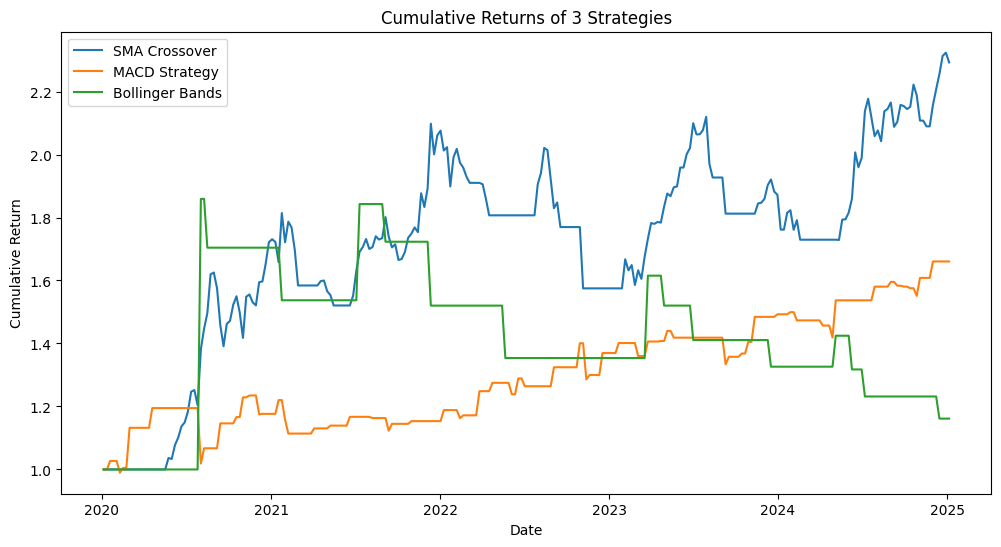

In [13]:
data[['SMA_Return', 'MACD_Return', 'BB_Return']] = data[['SMA_Return', 'MACD_Return', 'BB_Return']].fillna(0)
data[['Cumulative_SMA', 'Cumulative_MACD', 'Cumulative_BB']] = (1 + data[['SMA_Return', 'MACD_Return', 'BB_Return']]).cumprod()
# Vẽ so sánh
plt.figure(figsize=(12,6))
plt.plot(data['Date'], data['Cumulative_SMA'], label='SMA Crossover')
plt.plot(data['Date'], data['Cumulative_MACD'], label='MACD Strategy')
plt.plot(data['Date'], data['Cumulative_BB'], label='Bollinger Bands')
plt.title("Cumulative Returns of 3 Strategies")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

<h1>Xây dựng mô hình dự báo và BackTesting</h1>

In [14]:
data.fillna(0, inplace=True)

data.isnull().sum()

,0
index,0
Date,0
Volume,0
SMA_Return,0
Close,0
SMA3,0
SMA20,0
SMA_Signal,0
Position,0
MACD_Return,0


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

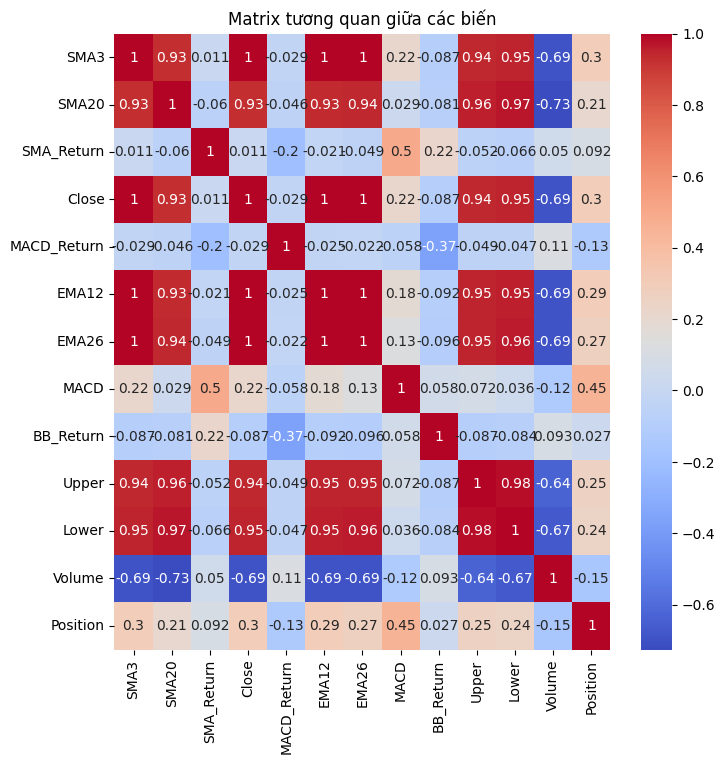

In [16]:
features = ['SMA3', 'SMA20', 'SMA_Return', 'Close', 'MACD_Return', 'EMA12', 'EMA26', 'MACD', 'BB_Return', 'Upper', 'Lower', 'Volume', 'Position']

corr_matrix = data[features].corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Matrix tương quan giữa các biến")
plt.show()

# => bỏ upper, bỏ SMA3, Close, Upper

In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

features = ['SMA_Return', 'MACD_Return', 'MACD', 'BB_Return', 'Volume', 'Lower', 'EMA26', 'Position']

# Tính VIF cho từng biến
X = data[features].dropna()
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
print(vif_data)

# Sau khi xóa các biến có độ tương quan cao thì các biến còn lại có chỉ số vif < 5 nên không cần tiếp tục xóa

       Feature         VIF
0   SMA_Return    1.530662
1  MACD_Return    1.251545
2         MACD    2.094698
3    BB_Return    1.211076
4       Volume    3.157603
5        Lower  134.624053
6        EMA26  150.840933
7     Position    4.032697


<h1>Dùng GridSearchCV để tìm tham số tốt nhất cho mô hình Logistic Regression</h1>

In [18]:
# Gắn nhãn tăng/giảm
data['Target'] = (data['Close'].shift(-1) > data['Close']).astype(int)

data.dropna(subset=features, inplace=True)
data.reset_index(drop=True, inplace=True)

# Xác định các đặc trưng (features) và mục tiêu (target)
X = data[features]
y = data['Target']

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Thiết lập tập cross-validation theo thời gian (walk forward)
tscv = TimeSeriesSplit(n_splits=5)

# Tạo lưới tham số (hyperparameter grid)
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],          # Độ phạt (regularization)
    'penalty': ['l2'],                            # Loại regularization (chỉ 'l2' cho solver='lbfgs')
    'solver': ['lbfgs'],                          # Solver hiệu quả cho logistic regression
    'max_iter': [500, 1000]                       # Đảm bảo hội tụ
}

# Tạo mô hình và GridSearch
model = LogisticRegression()
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=tscv,
                           scoring='accuracy',
                           n_jobs=-1)

# Fit dữ liệu
grid_search.fit(X_scaled, y)

best_params = grid_search.best_params_

# In ra kết quả tốt nhất
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated score:", grid_search.best_score_)


Best parameters: {'C': 0.001, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validated score: 0.5581395348837208


In [19]:
data.fillna(0, inplace=True)

<h1>Đưa các tham số tối ưu kết hợp với Walk Forward Optimization để đào tạo mô hình dự báo và so sánh kết quả thực tế và mô hình</h1>

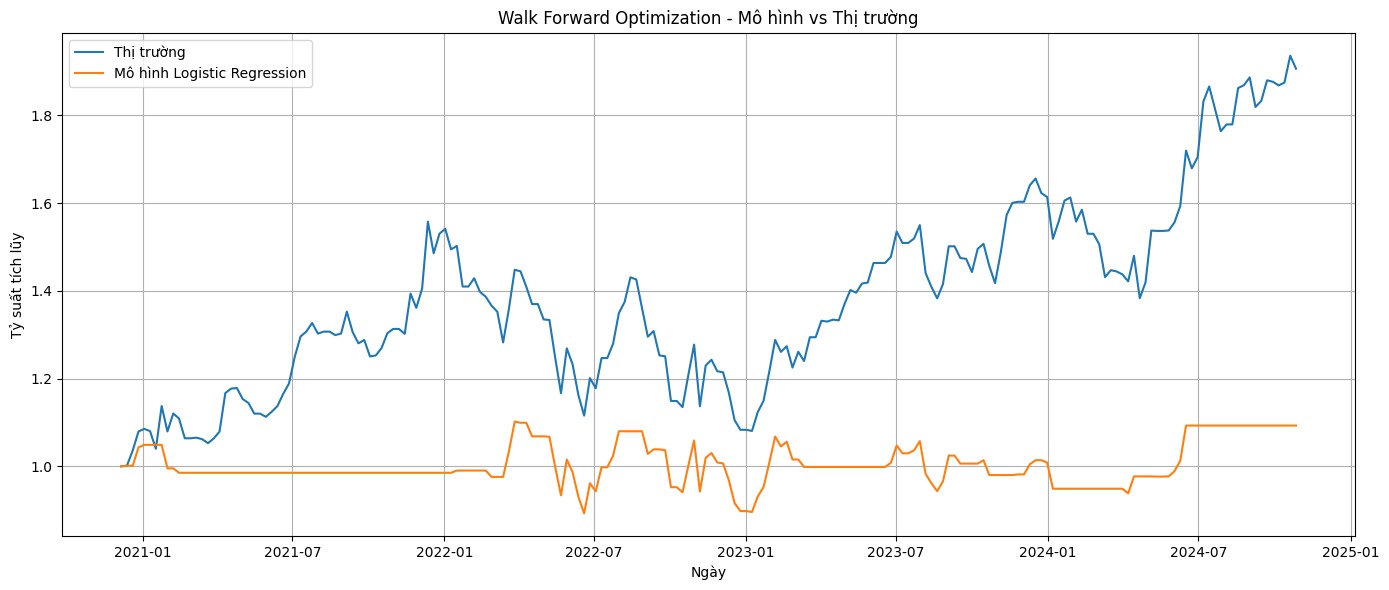

In [20]:
data.dropna(subset=features + ['Target'], inplace=True)
data.reset_index(drop=True, inplace=True)


# Cài đặt thông số cửa sổ Walk Forward
window_total = 60      # increased window size for more data in each fold
train_ratio = 0.8
train_size = int(window_total * train_ratio)
test_size = window_total - train_size
step_size = test_size   # di chuyển cửa sổ theo mỗi lần test

results = []

# Bắt đầu Walk Forward Loop
start = 0
while start + window_total <= len(data):
    train = data.iloc[start:start+train_size].copy()
    test = data.iloc[start+train_size:start+window_total].copy()

    # Kiểm tra xem tập huấn luyện có đủ cả hai lớp không
    if len(train['Target'].unique()) < 2:
        print(f"Skipping window starting at {data.iloc[start]['Date']} due to single class in training data.")
        start += step_size
        continue


    # Chuẩn hóa dữ liệu
    # Ensure features exist in the train and test dataframes
    X_train = scaler.fit_transform(train[features])
    X_test = scaler.transform(test[features])

    y_train = train['Target'].values
    y_test = test['Target'].values


    # Huấn luyện mô hình
    model = LogisticRegression(
        C=best_params['C'],
        penalty=best_params['penalty'],
        solver=best_params['solver'],
        max_iter=best_params['max_iter'],
        class_weight='balanced' # Add class_weight='balanced'
    )
    model.fit(X_train, y_train)

    # Dự đoán và lưu lại
    test['Prediction'] = model.predict(X_test)
    test['Prob_Up'] = model.predict_proba(X_test)[:, 1]

    # Calculate Strategy Return and Market Return - ensure 'Close' is available in test
    if 'Close' in test.columns:
        test['Strategy_Return'] = test['Prediction'].shift(1) * test['Close'].pct_change()
        test['Market_Return'] = test['Close'].pct_change()
    else:
        test['Strategy_Return'] = np.nan
        test['Market_Return'] = np.nan
        print(f"Warning: 'Close' column not found in test data for return calculation at window start {test.iloc[0]['Date']}.")


    results.append(test)

    start += step_size

# Chỉ nối các DataFrame nếu danh sách results không rỗng
if results:
    results_df = pd.concat(results)
else:
    results_df = pd.DataFrame() # Tạo DataFrame rỗng nếu không có kết quả nào

# Tổng hợp và đánh giá mô hình (Chỉ khi results_df không rỗng)
if not results_df.empty and 'Close' in results_df.columns: # Ensure 'Close' is in results_df for cumulative returns
    accuracy = accuracy_score(results_df['Target'], results_df['Prediction'])
    precision = precision_score(results_df['Target'], results_df['Prediction'], zero_division=0)
    recall = recall_score(results_df['Target'], results_df['Prediction'], zero_division=0)

    # Biểu đồ kết quả
    results_df['Cumulative_Strategy'] = (1 + results_df['Strategy_Return'].fillna(0)).cumprod()
    results_df['Cumulative_Market'] = (1 + results_df['Market_Return'].fillna(0)).cumprod()

    plt.figure(figsize=(14, 6))
    plt.plot(results_df['Date'], results_df['Cumulative_Market'], label='Thị trường')
    plt.plot(results_df['Date'], results_df['Cumulative_Strategy'], label='Mô hình Logistic Regression')
    plt.title('Walk Forward Optimization - Mô hình vs Thị trường')
    plt.xlabel('Ngày')
    plt.ylabel('Tỷ suất tích lũy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Không có kết quả nào từ Walk Forward Optimization hoặc 'Close' column is missing in results_df.")

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def evaluate_strategy(signal_col, return_col, df, strategy_name):
    returns = df[return_col].fillna(0)

    # === Sharpe Ratio ===
    # Ensure there's variation in returns to avoid division by zero
    if returns.std() == 0:
        sharpe_ratio = np.nan
    else:
        sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)

    # === Max Drawdown ===
    cumulative = (1 + returns).cumprod()
    roll_max = cumulative.cummax()
    drawdown = cumulative / roll_max - 1
    max_drawdown = drawdown.min()

    # === Classification metrics ===
    # Dự đoán: nếu signal trước đó là 1 -> dự đoán giá tăng
    df = df.copy()
    df['Pred'] = df[signal_col].shift(1)
    df['Actual'] = np.sign(df['Close'].pct_change())

    # Loại bỏ giá trị không hợp lệ và NaN
    mask = df['Pred'].isin([-1, 1]) & df['Actual'].isin([-1, 1])
    y_true = df.loc[mask, 'Actual']
    y_pred = df.loc[mask, 'Pred']

    # Only calculate classification metrics if there are valid predictions
    if len(y_true) > 0:
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
    else:
        acc = np.nan
        prec = np.nan
        rec = np.nan


    print(f"\n ĐÁNH GIÁ CHIẾN LƯỢC: {strategy_name}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f} {'✅' if sharpe_ratio > 1 else '❌'}") # Sharpe Ratio > 0 is a common benchmark
    print(f"Max Drawdown: {max_drawdown:.2%} {'✅' if max_drawdown > -0.20 else '❌'}") # Example benchmark for Max Drawdown
    print(f"Accuracy: {acc:.2%} {'✅' if acc > 0.5 else '❌'}") # Accuracy > 50% is better than random
    print(f"Precision: {prec:.2%} {'✅' if prec > 0.5 else '❌'}") # Precision > 50% means more correct positive predictions
    print(f"Recall: {rec:.2%} {'✅' if rec > 0.5 else '❌'}") # Recall > 50% means capturing more actual positive cases
    print("-" * 30)


# Gọi hàm đánh giá cho từng chiến lược
# Using the correct return columns from the 'data' DataFrame
evaluate_strategy('SMA_Signal', 'SMA_Return', data, 'MA Crossover')
# evaluate_strategy('Signal_RSI', 'RSI_Return', data, 'RSI Strategy') # RSI strategy was not implemented
evaluate_strategy('MACD_Signal', 'MACD_Return', data, 'MACD Strategy')
evaluate_strategy('Signal_BB', 'BB_Return', data, 'Bollinger Bands')


 ĐÁNH GIÁ CHIẾN LƯỢC: MA Crossover
Sharpe Ratio: 1.98 ✅
Max Drawdown: -24.93% ❌
Accuracy: 57.44% ✅
Precision: 60.59% ✅
Recall: 74.10% ✅
------------------------------

 ĐÁNH GIÁ CHIẾN LƯỢC: MACD Strategy
Sharpe Ratio: 1.66 ✅
Max Drawdown: -14.73% ✅
Accuracy: 65.08% ✅
Precision: 71.88% ✅
Recall: 63.89% ✅
------------------------------

 ĐÁNH GIÁ CHIẾN LƯỢC: Bollinger Bands
Sharpe Ratio: 0.48 ❌
Max Drawdown: -37.53% ❌
Accuracy: 45.83% ❌
Precision: 71.43% ✅
Recall: 31.25% ❌
------------------------------


In [22]:
# Tính toán và đánh giá mô hình Logistic Regression
# Using the results_df from the Walk Forward test for evaluation
strategy_name_lr = "Logistic Regression Model"
returns_lr = results_df['Strategy_Return'].fillna(0)

# === Sharpe Ratio ===
if returns_lr.std() == 0:
    sharpe_ratio_lr = np.nan
else:
    sharpe_ratio_lr = np.mean(returns_lr) / np.std(returns_lr) * np.sqrt(252)

# === Max Drawdown ===
cumulative_lr = (1 + returns_lr).cumprod()
roll_max_lr = cumulative_lr.cummax()
drawdown_lr = cumulative_lr / roll_max_lr - 1
max_drawdown_lr = drawdown_lr.min()

# Classification metrics are already calculated during the Walk Forward loop
acc_lr = accuracy_score(results_df['Target'], results_df['Prediction'])
prec_lr = precision_score(results_df['Target'], results_df['Prediction'], zero_division=0)
rec_lr = recall_score(results_df['Target'], results_df['Prediction'], zero_division=0)
f1 = f1_score(results_df['Target'], results_df['Prediction'])

print(f"\n📈 ĐÁNH GIÁ MÔ HÌNH: {strategy_name_lr}")
print(f"Sharpe Ratio: {sharpe_ratio_lr:.2f} {'✅' if sharpe_ratio_lr > 1 else '❌'}")
print(f"Max Drawdown: {max_drawdown_lr:.2%} {'✅' if max_drawdown_lr > -0.20 else '❌'}")
print(f"Accuracy: {acc_lr:.2%} {'✅' if acc_lr > 0.5 else '❌'}")
print(f"Precision: {prec_lr:.2%} {'✅' if prec_lr > 0.5 else '❌'}")
print(f"Recall: {rec_lr:.2%} {'✅' if rec_lr > 0.5 else '❌'}")
print(f"f1-scored: {f1:.2%} {'✅' if f1 > 0.6 else '❌'}")
print("-" * 30)


📈 ĐÁNH GIÁ MÔ HÌNH: Logistic Regression Model
Sharpe Ratio: 0.48 ❌
Max Drawdown: -18.98% ✅
Accuracy: 46.57% ❌
Precision: 51.85% ✅
Recall: 37.50% ❌
f1-scored: 43.52% ❌
------------------------------
